# Place Cell Formation
Following the de Almeida paper to create place cells from VCO-based grid cells; this strategy uses an experimentally-observed distribution of synaptic sizes (analogous to synaptic weights) to make more biologically plausible weight distributions.

## Import libraries and initialize standard VCO matrix
The "standard VCO matrix" is that found in the Welday _et al._, 2008 paper.

In [1]:
import vco
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Initializing VCO matrix
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol
phz_noise = 0

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

## de Almeida's distribution of synapse weights
This distribution is based on experimentally measured synapse sizes; we assume that synapse size and synaptic weight are directly proportional (given that vesicle size remains relatively constant, but vesicle number is proportional to area of a synapse). There are many small synapses (with small weights), and relatively few large synapses (with large weights).

In [3]:
def almeida_weights(size):
    A, B = 100.7, 0.02
    sigma = np.array([0.02, 0.018, 0.15])
    s = np.arange(0,0.2,0.0001)
    dist = A * (1 - np.exp(- s/sigma[0])) * (np.exp(- s/sigma[1]) + B * np.exp(- s/sigma[2]))
    pdf = dist/np.sum(dist)
    syn_diam = nprd.choice(s,size=size,p=pdf)
    weights = (syn_diam/0.2)*(syn_diam/(syn_diam+0.0314))
    return weights

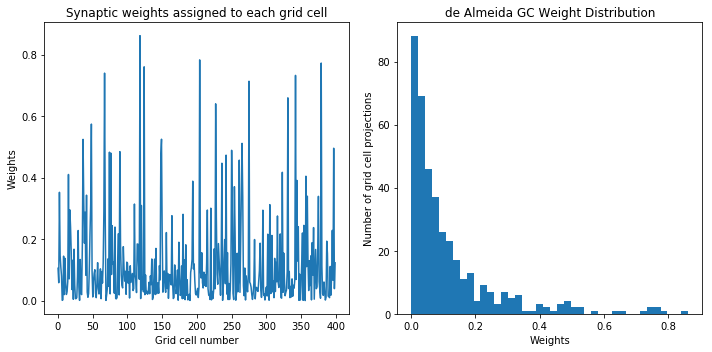

In [4]:
weights = almeida_weights(400)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(weights)
plt.xlabel('Grid cell number'); plt.ylabel('Weights')
plt.title('Synaptic weights assigned to each grid cell')
plt.subplot(122)
plt.hist(weights,bins=40)
plt.xlabel('Weights'); plt.ylabel('Number of grid cell projections')
plt.title('de Almeida GC Weight Distribution')

plt.tight_layout()

## Putative place cells using de Almeida weight distribution
Create place cells from random collections of grid cells using de Almeida's weight distribution.

First, we'll create three different collections of grid cells that can be used: a single row $\left( \rho = 0.14 \sqrt(3)^4 = 1.26 \right)$, a partial matrix (rows 2-4, i.e. $\rho = [0.42, 0.727, 1.26])$, or a full matrix.

In [5]:
full_row = np.full([6,12,4*12**3], np.nan)
row = 4
jdx = 0
for firstcol in range(4):
    for cell1 in range(12):
        for cell2 in range(12):
            for cell3 in range(12):
                full_row[row,firstcol,  jdx] = cell1
                full_row[row,firstcol+4,jdx] = cell2
                full_row[row,firstcol+8,jdx] = cell3
                jdx = jdx + 1

In [15]:
partial_matrix = np.full([6,12,2*4*12**3], np.nan)
jdx = 0
for row in range(2,4):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    partial_matrix[row,firstcol,  jdx] = cell1
                    partial_matrix[row,firstcol+4,jdx] = cell2
                    partial_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

In [16]:
full_matrix = np.full([6,12,6*4*12**3], np.nan)
jdx = 0
for row in range(6):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    full_matrix[row,firstcol,  jdx] = cell1
                    full_matrix[row,firstcol+4,jdx] = cell2
                    full_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

Now, we choose which subset of grid cells to use and create the grid cell outputs:

In [17]:
grid_weights = partial_matrix

In [18]:
size = 5
num_grids = grid_weights.shape[2]

grid_outputs = np.zeros([10*size, 10*size, num_grids])
for gc in range(num_grids):
    grid_outputs[:,:,gc], _ = vco.theta_to_hcn(VCOmat,grid_weights[:,:,gc],size)

Then we randomly sample `num_gc` grid cells from the de Almeida weight distribution to synapse onto each (of `num_places`) place cells. The grid cell inputs are linearly summed to create the place cell outputs.

In [19]:
num_places = 50
num_gc = 1500

place_cells = np.zeros([10*size, 10*size, num_places, 2])
weights = almeida_weights(num_gc)

for pc in range(num_places):
    idx = np.arange(num_grids)
    nprd.shuffle(idx)
    idx = idx[0:num_gc]
    for i, gc_ind in enumerate(idx):
        place_cells[:,:,pc,0] = place_cells[:,:,pc,0] + weights[i] * grid_outputs[:,:,gc_ind]  

Then, as in the paper, we set an all-or-nothing threshold for each place cells at $\left(1-k\right)$ of the global maximum firing rate; de Almeida calls this psuedo-winner-takes-all algorithm "**E%-max**". We store this thresholded firing rate map side-by-side with the raw place cell output.

In [31]:
k_thresh = 0.1
reset_val = np.amin(place_cells[:,:,:,0])
for pc in range(num_places):
    for x in range(place_cells.shape[0]):
        for y in range(place_cells.shape[1]):
            if place_cells[x,y,pc,0] >= (1-k_thresh)*np.max(place_cells[x,y,:,0]):
                place_cells[x,y,pc,1] = place_cells[x,y,pc,0]
            else:
                place_cells[x,y,pc,1] = reset_val

## Plotting de Almeida random place cells

These place cells, created above, are made with 1500 grid cell inputs each.

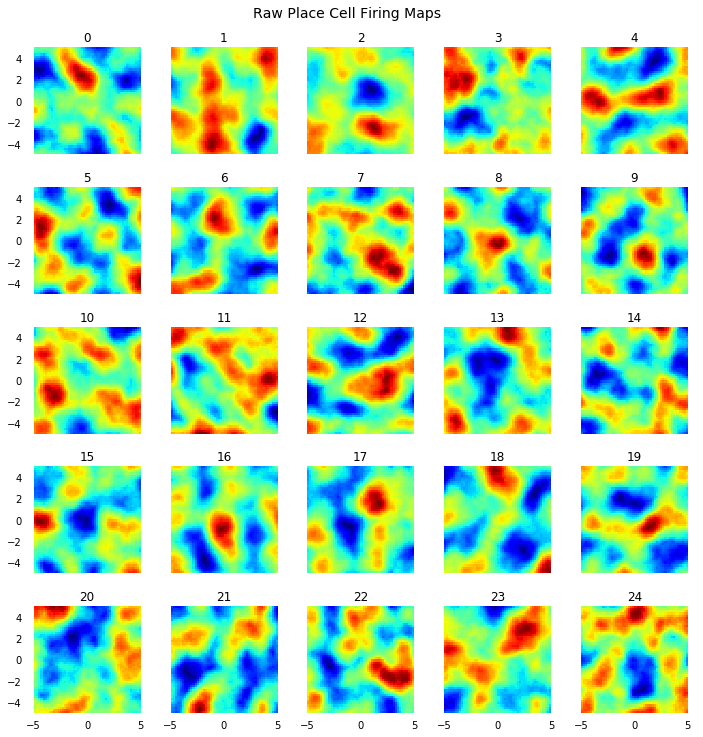

In [35]:
vco.plot_many(place_cells[:,:,:25,0],size)
plt.suptitle('Raw Place Cell Firing Maps',fontsize=14,y=1.02)

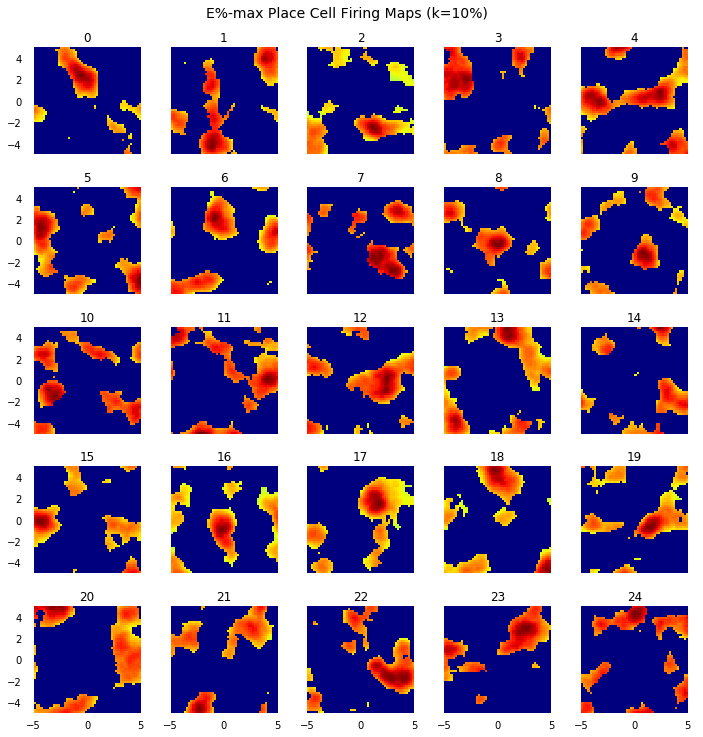

In [34]:
vco.plot_many(place_cells[:,:,:25,1],size)
plt.suptitle('E%-max Place Cell Firing Maps (k=10%)',fontsize=14,y=1.02)

## Issues with E%-max
The E%-max algorithm is, in my opinion, inherently flawed; it requires knowing the instantaneous activity of all cells at any given time step. With that instantaneous knowledge of all network dynamics, the algorithm then adaptively thresholds all place cell firing by only allowing. However, it's unclear to me how this could be implemented without a running tab of the highest firing rate and constant comparisons between cell input dynamics and this running tab. Is there a way to implement this in network dynamics alone, without these comparisons?